# Урок 4. Построение алгоритма дерева решений

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import pandas as pd

In [2]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 
               1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1,
              0, 1, 0, 1, 1], dtype = np.float64)

In [3]:
df = pd.DataFrame(X.T)
df['y'] = y
df

,0,1,2,3,y
0,1.0,1.0,500.0,1.0,0.0
1,1.0,1.0,700.0,1.0,0.0
2,1.0,2.0,750.0,2.0,1.0
3,1.0,1.0,600.0,1.0,0.0
4,1.0,3.0,1450.0,2.0,1.0
5,1.0,0.0,800.0,1.0,0.0
6,1.0,5.0,1500.0,3.0,1.0
7,1.0,10.0,2000.0,3.0,0.0
8,1.0,1.0,450.0,1.0,1.0
9,1.0,2.0,1000.0,2.0,1.0


In [4]:
df.sort_values(by='y')

,0,1,2,3,y
0,1.0,1.0,500.0,1.0,0.0
1,1.0,1.0,700.0,1.0,0.0
3,1.0,1.0,600.0,1.0,0.0
5,1.0,0.0,800.0,1.0,0.0
7,1.0,10.0,2000.0,3.0,0.0
2,1.0,2.0,750.0,2.0,1.0
4,1.0,3.0,1450.0,2.0,1.0
6,1.0,5.0,1500.0,3.0,1.0
8,1.0,1.0,450.0,1.0,1.0
9,1.0,2.0,1000.0,2.0,1.0


In [5]:
x = X[3].copy()

In [6]:
y[x > 1]

array([1., 1., 1., 0., 1.])

In [7]:
x = X[2].copy()

In [8]:
y[x >= 1000]

array([1., 1., 0., 1.])

In [9]:
y[x < 1000]

array([0., 0., 1., 0., 0., 1.])

Неопределенность Джини (Gini impurity): $$G = \sum\limits_k p_k(1 - p_k)^2$$

In [10]:
def gini(x, y, t):
    
    qty_left = len(y[x < t])
    qty_right = len(y[x >= t])
    
    if qty_left == 0 or qty_right == 0:
        return np.inf
    
    qty0_left = np.sum(y[x < t] == 0)
    qty1_right = np.sum(y[x >= t] == 1)
    
    p0 = qty0_left/qty_left
    p1 = qty1_right/qty_right
    p = np.array([p0, p1])
    
    g = np.sum(p*(1 - p))
    
    return g

In [11]:
gini(x, y, t=1000)

0.4097222222222222

In [12]:
for t in x:
    print(f'Порог: {t}, Gini: {gini(x, y, t)}')

Порог: 500.0, Gini: 0.24691358024691357
Порог: 700.0, Gini: 0.46712018140589573
Порог: 750.0, Gini: 0.4097222222222222
Порог: 600.0, Gini: 0.5
Порог: 1450.0, Gini: 0.46712018140589573
Порог: 800.0, Gini: 0.48
Порог: 1500.0, Gini: 0.5
Порог: 2000.0, Gini: 0.24691358024691357
Порог: 450.0, Gini: inf
Порог: 1000.0, Gini: 0.4097222222222222


 ### ООП реализация

In [13]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [14]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction_classification = self.predict()
        self.prediction_regression = self.predict_reg()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

    def predict_reg(self):
        #  найдем значение как среднее по выборке   
        prediction = np.mean(self.labels)
        return prediction  

In [15]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [16]:
# Расчет качества для задачи классификации
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [17]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [18]:
# Нахождение наилучшего разбиения для задачи классификации
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [19]:
# Построение дерева классификации с помощью рекурсивной функции
def build_tree_classification(data, labels, tree_depth=1, max_depth=50):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_classification(true_data, true_labels, tree_depth, max_depth)
    false_branch = build_tree_classification(false_data, false_labels, tree_depth, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [20]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction_classification
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [21]:
def predict_class(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

## Проверим работоспособность дерева классификации


In [22]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 5, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=2020)

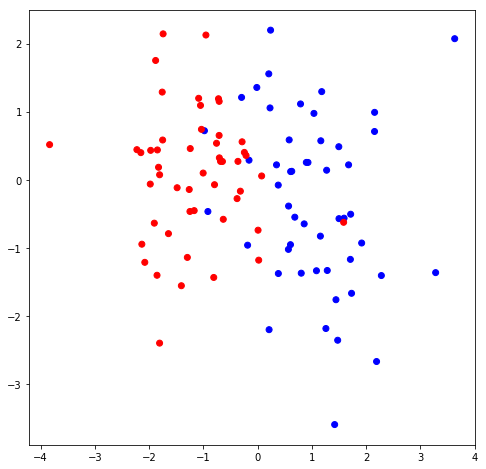

In [23]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [24]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [25]:
custom_tree = build_tree_classification(train_data, train_labels, max_depth=3)

In [26]:
custom_tree

In [27]:
y_train_pred = predict_class(train_data, custom_tree)
y_test_pred = predict_class(test_data, custom_tree)

In [28]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [29]:
print(accuracy_metric(train_labels, y_train_pred))
print(accuracy_metric(test_labels, y_test_pred))

91.42857142857143
96.66666666666667


In [30]:
# Напечатаем ход нашего дерева
def print_tree_classification(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction_classification)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree_classification(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree_classification(node.false_branch, spacing + "  ")
    
print_tree_classification(custom_tree)

Индекс 0
Порог 0.07414659120138944
--> True:
  Индекс 3
  Порог 0.4760458994956591
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Индекс 2
  Порог -0.9933052480886307
  --> True:
    Прогноз: 1
  --> False:
    Прогноз: 1


In [31]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [32]:
y = df['y']
X = df.drop(columns='y')

In [33]:
sk_tree = DecisionTreeClassifier(random_state=2020).fit(classification_data, classification_labels)

In [34]:
sk_tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')

In [43]:
export_graphviz(sk_tree, out_file='tree2.dot', 
#                 feature_names = classification_data.columns,
                class_names = ['non-seizure', 'epileptic seizure'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [47]:
import os
path_to_graphviz = 'C:\\Users\\Nataly\\Documents\\Data Science\\аогоритмы\\Lesson4' # your path to graphviz (C:\\Program Files (x86)\\Graphviz2.38\\bin\\ for example) 
os.environ["PATH"] += os.pathsep + path_to_graphviz

In [ ]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree2.dot', '-o', 'tree2.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree2.png')

### Домашнее задание.  

#### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.) 

Здесь в коде уже реализованы некоторые критерии останова. Изначально задается max_depth=50 - это ограничение максимальной глубины дерева. Этот критейри довольно грубый, поскольку мы останавливаем построение не опираясь на какие-либо данные. Далее if quality == 0 - останавливаем, если нет прироста качества.

In [ ]:
def build_tree_classification(data, labels, tree_depth=1, max_depth=50):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_classification(true_data, true_labels, tree_depth, max_depth)
    false_branch = build_tree_classification(false_data, false_labels, tree_depth, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

В коде ниже реализован критерий останова по количеству объектов в узле. Этот критерий проверяет, сколько объектов оказалось в данном узле. Если их больше, чем n, то разбиение продолжается, а если меньше или равно, чем n, то процесс построения останавливается в этом узле.

In [ ]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

#### 2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [35]:
# Расчёт дисперсии значений (вместо gini)
def dispersion(labels):
    return np.std(labels)


# Расчет качества для задачи регрессии
def quality_regression(left_labels, right_labels, current_dispersion):
    
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) 
    
    return current_dispersion - p * dispersion(left_labels) - (1 - p) * dispersion(right_labels)


# аналог classify_object для регрессии
def predict_object(obj, node):
    
    if isinstance(node, Leaf):
        answer = node.prediction_regression
        return answer

    if obj[node.index] <= node.t:
        return predict_object(obj, node.true_branch)
    else:
        return predict_object(obj, node.false_branch)

    
# аналог predict_class для регрессии
def predict_value(data, tree):
    
    val = []
    
    for obj in data:
        prediction = classify_object(obj, tree)
        val.append(prediction)

    return val
    

# Нахождение наилучшего разбиения для задачи регрессии
def find_best_split_regression(data, labels):
    
    min_leaf = 5

    current_dispersion = dispersion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_regression(true_labels, false_labels, current_dispersion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева регрессии с помощью рекурсивной функции
def build_tree_regression(data, labels, tree_depth=1, max_depth=50):

    quality, t, index = find_best_split_regression(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_regression(true_data, true_labels, tree_depth, max_depth)
    false_branch = build_tree_regression(false_data, false_labels, tree_depth, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


In [36]:
reg_data, reg_labels = datasets.make_regression(n_features = 2,
                                                n_informative = 2,
                                                random_state=5,
                                                n_samples=100)

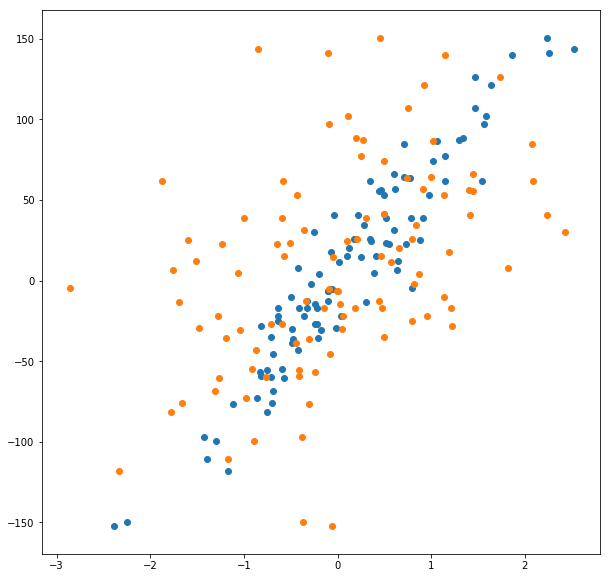

In [40]:
plt.figure(figsize=(10,10))
plt.scatter(reg_data[:, 0], reg_labels)
plt.scatter(reg_data[:, 1], reg_labels)

In [41]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(reg_data, 
                                                                                     reg_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [42]:
regression_tree = build_tree_regression(train_data, train_labels)

In [43]:
train_pred = predict_value(train_data, regression_tree)

In [44]:
prediction = predict_value(test_data, regression_tree)

In [45]:
def mse_metric(actual, predicted):
    return np.average((actual - predicted) ** 2, axis=0)

In [46]:
train_mse = mse_metric(train_labels, train_pred)
train_mse

578.7183158212204

In [47]:
test_mse = mse_metric(test_labels, prediction)
test_mse

605.9225763356941

In [48]:
def print_tree_regression(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction_regression)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree_regression(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree_regression(node.false_branch, spacing + "  ")
    
print_tree_regression(regression_tree)

Индекс 0
Порог -0.10061434630710828
--> True:
  Индекс 0
  Порог -0.8568531547160899
  --> True:
    Прогноз: -109.75655471490919
  --> False:
    Индекс 0
    Порог -0.5732155560138283
    --> True:
      Прогноз: -54.35634172577482
    --> False:
      Индекс 1
      Порог -0.3058530211666308
      --> True:
        Прогноз: -29.105630694331246
      --> False:
        Прогноз: -10.772916465924025
--> False:
  Индекс 0
  Порог 0.9068894675659355
  --> True:
    Индекс 1
    Порог 0.6566194702604272
    --> True:
      Индекс 1
      Порог -1.0650326193820066
      --> True:
        Прогноз: 7.798014762375311
      --> False:
        Индекс 0
        Порог 0.41367880834311616
        --> True:
          Прогноз: 17.019366109004096
        --> False:
          Прогноз: 35.95087900163848
    --> False:
      Индекс 0
      Порог 0.34691932708774675
      --> True:
        Прогноз: 37.4238776327042
      --> False:
        Прогноз: 61.9558421220885
  --> False:
    Индекс 0
    Порог 1.3

In [52]:
#посчитаем R2, такая метрика для меня более понятна.
def r_2(y, y_pred):
    return 1 - ((sum((y_pred - y)**2)) / (sum((y - np.mean(y))**2)))

r_2(test_labels, prediction)

0.823913382089906